# Does the size of convolution kernels affect classifier performance? (Assuming parameter count is the same)

In [1]:
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import *
from keras.models import Model
from keras import backend as K

Using TensorFlow backend.


In [2]:
import os
import numpy as np
import Bio
from Bio import SeqIO
import seaborn as sns
import pandas as pd
import Bio.motifs
%matplotlib inline
from sklearn import model_selection
import seaborn as sns
from matplotlib import pyplot as plt
import sklearn
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import scipy
sns.set_context('notebook')

In [3]:
if not os.path.isdir('/home/jtao/analysis/genomic_grammar_analysis/'):
    os.mkdir('/home/jtao/analysis/genomic_grammar_analysis')
os.chdir('/home/jtao/analysis/genomic_grammar_analysis')

## Functions

In [11]:
def convert_sequences_to_array(sequences):
    '''
    inputs: sequence of nucleotides represented as a string composed of A, C, G, T
    outputs: a list of numpy array representations of a sequence with:
             A = [1, 0, 0, 0]
             C = [0, 1, 0, 0]
             G = [0, 0, 1, 0]
             T = [0, 0, 0, 1]
             
    '''

    nucleotide_array_dict = {'A': [1, 0, 0, 0],
                             'C': [0, 1, 0, 0],
                             'G': [0, 0, 1, 0],
                             'T': [0, 0, 0, 1],
                             'N': [0.25,0.25,0.25,0.25]}

    sequence_array_list = []
    for seq in sequences:
        seq_array = []
        for nuc in seq:
            seq_array.append(nucleotide_array_dict[nuc])
        seq_array = np.array(seq_array, dtype=np.float16)
        sequence_array_list.append(seq_array)
    sequence_array_list = np.array(sequence_array_list,dtype=np.float16)
    return sequence_array_list

In [12]:
def quantile_normalize_df(df_input):
    df = df_input.copy()
    #compute rank
    dic = {}
    for col in df:
        dic.update({col : sorted(df[col])})
    sorted_df = pd.DataFrame(dic)
    rank = sorted_df.mean(axis = 1).tolist()
    #sort
    for col in df:
        t = np.searchsorted(np.sort(df[col]), df[col])
        df[col] = [rank[i] for i in t]
    return df

## Read KLA data

In [13]:
# positive_seqRecords = list(SeqIO.parse('./fasta_files/c57bl6_il4-24h_peaks.fa', 'fasta'))
# negative_seqRecords = list(SeqIO.parse('./background_files/c57bl6_il4-24h_peaks_background.fasta', 'fasta'))

positive_seqRecords = list(SeqIO.parse('./peak_sequences/c57bl6_kla-1h_peaks.fasta', 'fasta'))
negative_seqRecords = list(SeqIO.parse('./background_files/c57bl6_kla-1h_background.fasta', 'fasta'))[:len(positive_seqRecords)]

fasta_seq = [str(x.seq[:200]) for x in positive_seqRecords] + [str(x[:200].seq) for x in negative_seqRecords]

fasta_rc_seq = [str(x[:200].reverse_complement().seq) for x in positive_seqRecords] + \
    [str(x[:200].reverse_complement().seq) for x in negative_seqRecords]

sequence_arrays = convert_sequences_to_array(fasta_seq)

sequence_rc_arrays = convert_sequences_to_array(fasta_rc_seq)


labels = [1 for x in positive_seqRecords] + [0 for x in negative_seqRecords]
labels = np.array(labels)

x_train, x_test, x_rc_train, x_rc_test, y_train, y_test = model_selection.train_test_split(sequence_arrays, sequence_rc_arrays, labels, test_size=0.2)

num_classes = 2
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

## Define Convolution Model

In [48]:
total_seq_length = len(fasta_seq[0])

In [49]:
def get_convolution_model(
    total_seq_length=200,
    seq_size = 150,
    num_classes = 2,
    num_motifs = 25,
    motif_size = 20,
    num_dense_neurons = 25, 
    dropout_rate = 0.25
    ):
    input_fwd = Input(shape=(total_seq_length,4), name='input_fwd')
    input_rev = Input(shape=(total_seq_length,4), name='input_rev')

    # find motifs
    convolution_layer = Conv1D(filters=num_motifs, 
        kernel_size=motif_size,
        activation='relu',
        input_shape=(total_seq_length,4),
        name='convolution_layer',
        padding = 'same'
        )
    forward_motif_scores = convolution_layer(input_fwd)
    reverse_motif_scores = convolution_layer(input_rev)

    # crop motif scores to avoid parts of sequence where motif score is computed in only one direction
    to_crop = int((total_seq_length - seq_size)/2)
    crop_layer = Cropping1D(cropping=(to_crop, to_crop), 
        name='crop_layer')
    cropped_fwd_scores = crop_layer(forward_motif_scores)
    cropped_rev_scores = crop_layer(reverse_motif_scores)

    # calculate max scores for each orientation
    seq_pool_layer = MaxPool1D(pool_size=seq_size)
    max_fwd_scores = seq_pool_layer(cropped_fwd_scores)
    max_rev_scores = seq_pool_layer(cropped_rev_scores)

    # calculate max score for strand
    orientation_max_layer = Maximum()
    max_seq_scores = orientation_max_layer([max_fwd_scores, max_rev_scores])

    # fully connected layer
    dense_out = Dense(num_dense_neurons, activation='relu', 
                     )(max_seq_scores)

    # drop out
    drop_out = Dropout(0.25)(dense_out)

    # make prediction
    flattened = Flatten()(drop_out)
    predictions = Dense(num_classes,
                        activation = 'softmax', 
                       )(flattened)
    
    # define and compile model
    convolution_model = Model(inputs=[input_fwd, input_rev], outputs=predictions)

    return convolution_model

In [63]:
convolution_model = get_convolution_model(total_seq_length=200,
    seq_size = 150,
    num_classes = 2,
    num_motifs = 16,
    motif_size = 24,
    num_dense_neurons = 32, 
    dropout_rate = 0.5)

In [64]:
convolution_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_fwd (InputLayer)           (None, 200, 4)        0                                            
____________________________________________________________________________________________________
input_rev (InputLayer)           (None, 200, 4)        0                                            
____________________________________________________________________________________________________
convolution_layer (Conv1D)       (None, 200, 16)       1552                                         
____________________________________________________________________________________________________
crop_layer (Cropping1D)          (None, 150, 16)       0                                            
___________________________________________________________________________________________

In [65]:
convolution_model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

In [16]:
convolution_model.fit([x_train, x_rc_train], y_train,
          batch_size=128,
          epochs=10,
          verbose=1,
          validation_data=([x_test, x_rc_test], y_test))


Train on 34841 samples, validate on 8711 samples
Epoch 1/10
34841/34841 [==============================] - 9s - loss: 0.3787 - acc: 0.8318 - val_loss: 0.3953 - val_acc: 0.8248
Epoch 2/10
34841/34841 [==============================] - 5s - loss: 0.3707 - acc: 0.8363 - val_loss: 0.3793 - val_acc: 0.8340
Epoch 3/10
34841/34841 [==============================] - 5s - loss: 0.3664 - acc: 0.8391 - val_loss: 0.3810 - val_acc: 0.8318
Epoch 4/10
34841/34841 [==============================] - 5s - loss: 0.3635 - acc: 0.8399 - val_loss: 0.3806 - val_acc: 0.8319
Epoch 5/10
34841/34841 [==============================] - 5s - loss: 0.3578 - acc: 0.8435 - val_loss: 0.3821 - val_acc: 0.8323
Epoch 6/10
34841/34841 [==============================] - 5s - loss: 0.3567 - acc: 0.8427 - val_loss: 0.3815 - val_acc: 0.8316
Epoch 7/10
34841/34841 [==============================] - 5s - loss: 0.3561 - acc: 0.8433 - val_loss: 0.3890 - val_acc: 0.8252
Epoch 8/10
34841/34841 [==============================] - 5s -

In [17]:
probs = convolution_model.predict([x_test, x_rc_test])

sklearn.metrics.roc_auc_score([y[1] for y in y_test], probs[:,1], )

0.9116724301528729

## Try different k-mer sizes

In [18]:
x_train, x_test, x_rc_train, x_rc_test, y_train, y_test = model_selection.train_test_split(sequence_arrays, sequence_rc_arrays, labels, test_size=0.2)

num_classes = 2
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [29]:
all_rocs = []
all_accuracies = []
all_precisions = []
k_list = []
for k in range(2,25):
    max_kmers = 4**k
    param_count=0
    kmers_to_use = 0
    while param_count <= 1552 - (4*k+1):
        kmers_to_use +=1
        param_count += (4*k+1)
    kmers_to_use = min(kmers_to_use, max_kmers)

    
    
    current_model = get_convolution_model(total_seq_length=200,
    seq_size = 150,
    num_classes = 2,
    num_motifs = kmers_to_use,
    motif_size = k,
    num_dense_neurons = 32, 
    dropout_rate = 0.5)
    
    current_model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])
    current_model.fit([x_train, x_rc_train], y_train,
          batch_size=128,
          epochs=10,
          verbose=1,
          validation_data=([x_test, x_rc_test], y_test))
    
    probs = current_model.predict([x_test, x_rc_test])

    roc = sklearn.metrics.roc_auc_score([y[1] for y in y_test], probs[:,1], )
    precision = sklearn.metrics.precision_score([y[1] for y in y_test], [1 if x > 0.5 else 0 for x in probs[:,1]])
    acc = sklearn.metrics.accuracy_score([y[1] for y in y_test], [1 if x > 0.5 else 0 for x in probs[:,1]])
    print(k, max_kmers, kmers_to_use, param_count)
    print(roc, precision, acc)
    
    all_rocs.append(roc)
    all_accuracies.append(acc)
    all_precisions.append(precision)
    k_list.append(k)

Train on 34841 samples, validate on 8711 samples
Epoch 1/10
34841/34841 [==============================] - 3s - loss: 0.6904 - acc: 0.5256 - val_loss: 0.6876 - val_acc: 0.5371
Epoch 2/10
34841/34841 [==============================] - 2s - loss: 0.6879 - acc: 0.5375 - val_loss: 0.6864 - val_acc: 0.5444
Epoch 3/10
34841/34841 [==============================] - 2s - loss: 0.6875 - acc: 0.5418 - val_loss: 0.6860 - val_acc: 0.5444
Epoch 4/10
34841/34841 [==============================] - 2s - loss: 0.6873 - acc: 0.5443 - val_loss: 0.6860 - val_acc: 0.5444
Epoch 5/10
34841/34841 [==============================] - 2s - loss: 0.6867 - acc: 0.5459 - val_loss: 0.6862 - val_acc: 0.5444
Epoch 6/10
34841/34841 [==============================] - 2s - loss: 0.6871 - acc: 0.5448 - val_loss: 0.6855 - val_acc: 0.5444
Epoch 7/10
34841/34841 [==============================] - 2s - loss: 0.6865 - acc: 0.5438 - val_loss: 0.6852 - val_acc: 0.5444
Epoch 8/10
34841/34841 [==============================] - 2s -

34841/34841 [==============================] - 5s - loss: 0.4310 - acc: 0.8041 - val_loss: 0.4359 - val_acc: 0.7949
7 16384 53 1537
0.8803780291476423 0.7687687687687688 0.7948570772586385
Train on 34841 samples, validate on 8711 samples
Epoch 1/10
34841/34841 [==============================] - 6s - loss: 0.6438 - acc: 0.6355 - val_loss: 0.5507 - val_acc: 0.7360
Epoch 2/10
34841/34841 [==============================] - 5s - loss: 0.5080 - acc: 0.7582 - val_loss: 0.4612 - val_acc: 0.7827
Epoch 3/10
34841/34841 [==============================] - 5s - loss: 0.4645 - acc: 0.7855 - val_loss: 0.4411 - val_acc: 0.7966
Epoch 4/10
34841/34841 [==============================] - 5s - loss: 0.4403 - acc: 0.7985 - val_loss: 0.4388 - val_acc: 0.7937
Epoch 5/10
34841/34841 [==============================] - 5s - loss: 0.4282 - acc: 0.8045 - val_loss: 0.4246 - val_acc: 0.8039
Epoch 6/10
34841/34841 [==============================] - 5s - loss: 0.4185 - acc: 0.8111 - val_loss: 0.4274 - val_acc: 0.8032


34841/34841 [==============================] - 5s - loss: 0.3660 - acc: 0.8427 - val_loss: 0.3973 - val_acc: 0.8242
Epoch 9/10
34841/34841 [==============================] - 5s - loss: 0.3629 - acc: 0.8448 - val_loss: 0.3959 - val_acc: 0.8213
Epoch 10/10
34841/34841 [==============================] - 5s - loss: 0.3555 - acc: 0.8490 - val_loss: 0.3772 - val_acc: 0.8372
13 67108864 29 1537
0.9122656114151739 0.8370457209847597 0.8372173114452991
Train on 34841 samples, validate on 8711 samples
Epoch 1/10
34841/34841 [==============================] - 6s - loss: 0.6414 - acc: 0.6309 - val_loss: 0.5468 - val_acc: 0.7485
Epoch 2/10
34841/34841 [==============================] - 5s - loss: 0.4934 - acc: 0.7670 - val_loss: 0.4476 - val_acc: 0.7905
Epoch 3/10
34841/34841 [==============================] - 5s - loss: 0.4351 - acc: 0.8036 - val_loss: 0.4213 - val_acc: 0.8082
Epoch 4/10
34841/34841 [==============================] - 5s - loss: 0.4127 - acc: 0.8167 - val_loss: 0.4116 - val_acc: 0.

34841/34841 [==============================] - 5s - loss: 0.4026 - acc: 0.8201 - val_loss: 0.4067 - val_acc: 0.8171
Epoch 7/10
34841/34841 [==============================] - 5s - loss: 0.3932 - acc: 0.8255 - val_loss: 0.4094 - val_acc: 0.8135
Epoch 8/10
34841/34841 [==============================] - 5s - loss: 0.3896 - acc: 0.8263 - val_loss: 0.4018 - val_acc: 0.8154
Epoch 9/10
34841/34841 [==============================] - 5s - loss: 0.3830 - acc: 0.8312 - val_loss: 0.4000 - val_acc: 0.8188
Epoch 10/10
34841/34841 [==============================] - 5s - loss: 0.3787 - acc: 0.8332 - val_loss: 0.3980 - val_acc: 0.8187
19 274877906944 20 1540
0.9032442983339971 0.785804549283909 0.8187349328435312
Train on 34841 samples, validate on 8711 samples
Epoch 1/10
34841/34841 [==============================] - 8s - loss: 0.6759 - acc: 0.5734 - val_loss: 0.6186 - val_acc: 0.7291
Epoch 2/10
34841/34841 [==============================] - 5s - loss: 0.5360 - acc: 0.7445 - val_loss: 0.4622 - val_acc:

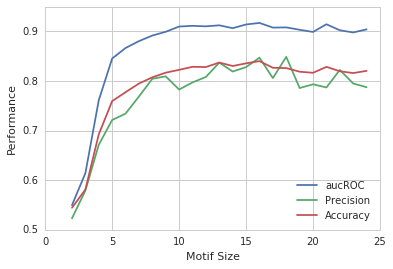

In [30]:
with sns.axes_style('whitegrid'):
    plt.plot(k_list, all_rocs, label = 'aucROC')
    plt.plot(k_list, all_precisions, label = 'Precision')
    plt.plot(k_list, all_accuracies, label = 'Accuracy')
    plt.legend(loc='lower right')
    plt.xlabel('Motif Size')
    plt.ylabel('Performance')